# Adaptative Impedance Controller 

Install the python libraries

In [1]:
from IPython.display import clear_output
from IPython.display import Image


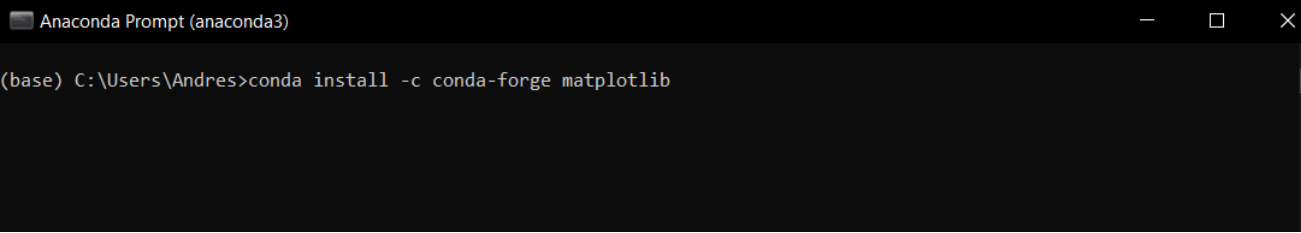

In [2]:
Image(filename='pictures/anacondapromt.png')

In [3]:
import time
import serial         #conda install -c anaconda pyserial
import numpy as np    #conda install -c anaconda numpy
import numpy.linalg as la
from datetime import datetime
import math
import json          #conda install -c jmcmurray json  
from scipy import stats  #conda install -c anaconda scipy
import matplotlib.pyplot as plt  #conda install -c conda-forge matplotlib

***
$\mathbf{\text{Basic Control Functions}}$<br>
***

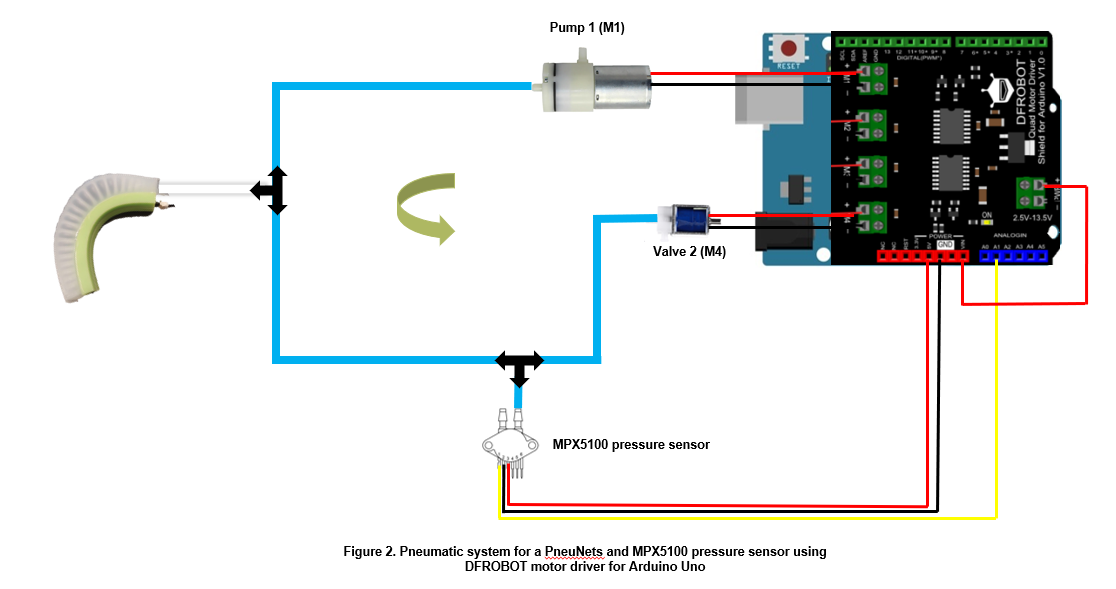

In [4]:
Image(filename='pictures/pneumaticsystem.png')

In [5]:
def star_communication(port):
    ser = serial.Serial(port, 115200, timeout=1)   #Include the number of the serial port
    return ser
    
def close_communication(ser):
    motor_control(ser,1)
    ser.close()


def read_data(ser, degree):
    #ser_bytes = ser.readline()
    ser.flushInput()
    
    cmd='r'+str(degree)+'\n'
    ser.write(bytes(cmd, encoding='ascii'))
    
    time.sleep(0.015)
    ser_bytes = ser.readline(ser.inWaiting())
    decoded_bytes = ser_bytes.decode()
    if len(decoded_bytes)>0 :
        decoded_bytes=decoded_bytes.strip()
        separated_data=decoded_bytes.split(",")
        if len(separated_data[0])>=4:
            integer_data = [i for i in separated_data]
            integer_array= np.array(integer_data)
        else:
            integer_array=np.zeros(5)
            integer_array[0]=2000
    else:
        integer_array=np.zeros(5)
        integer_array[0]=2000
    return integer_array

    
def feedback_data(ser, degree):              #current angle, current pressure, set_point(pressure or angle controller depends of the control), motor_speed
    integer_array=read_data(ser,degree)
    while len(integer_array)<5 or integer_array[0]==2000:
        integer_array=read_data(ser, degree)
    integer_array2=integer_array
    return integer_array2

def feedback_data2(ser, degree):              #current angle, current pressure, set_point(pressure or angle controller depends of the control), motor_speed
    integer_array=read_data(ser,degree)
    integer_array2=integer_array
    return integer_array2




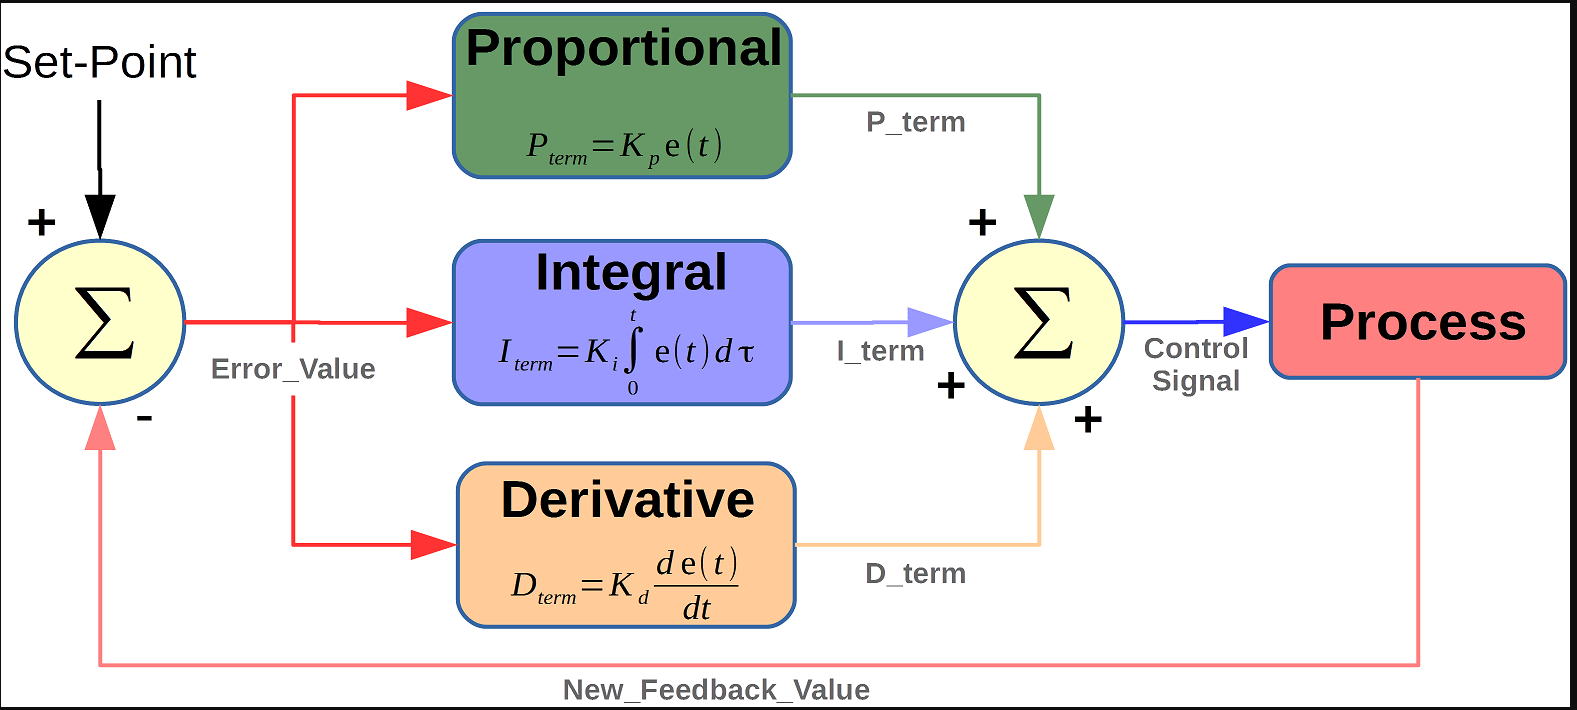

In [6]:
Image(filename='pictures/pid.png')

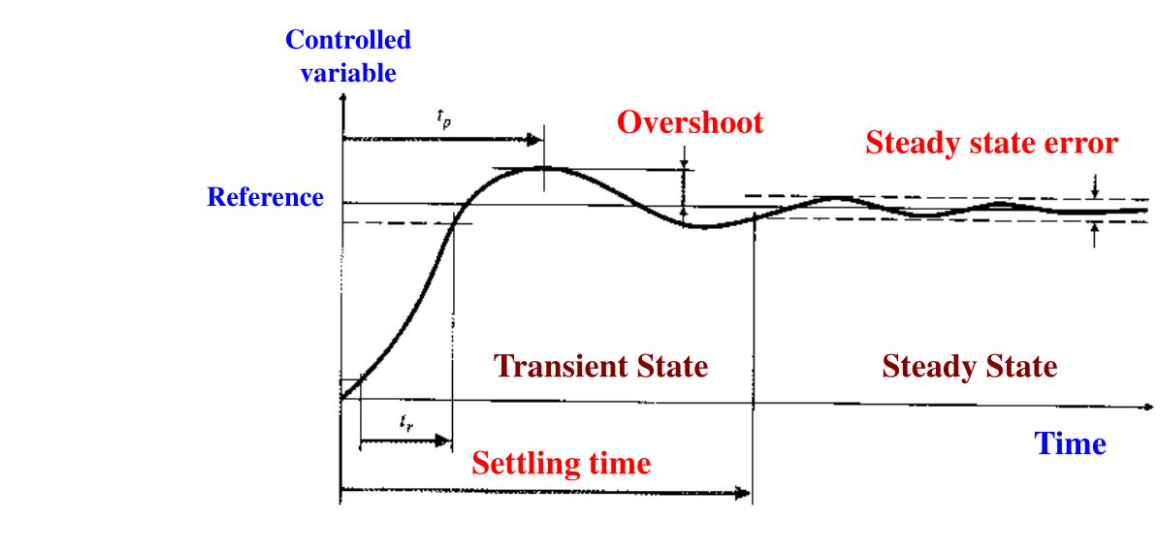

In [7]:
Image(filename='pictures/pid_response.png')

In [8]:
def motor_control(ser, speed_val):    #speed on the range of +255 to -255, Negative values just open the valve and stop the pump, 0 stops the pump but valve is still working
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_speed=str(speed_val)
    cmd='m'+motor_speed+'\n'
    print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))

def pressure_control(ser, pressure_val):    #pressure on the range of 0 to +25 kpa
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_pressure=str(pressure_val)
    cmd='p'+motor_pressure+'\n'
    #print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))
    
def bend_control(ser, bend_val):    #angle on the range of 0 to +180
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_bend=str(bend_val)
    cmd='a'+motor_bend+'\n'
    #print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))


1.&emsp;Demo code for control functions usage <br>

In [ ]:
ser=star_communication('COM14')
motor_control(ser,50)        #Activating speed control with setpoint at 50
time.sleep(5)
pressure_control(ser, 22)    #Activating pressure control with setpoint at 22
time.sleep(5)
bend_control(ser, 90)        #Activating angle control with setpoint at 90
time.sleep(5)
values=feedback_data(ser)    #Getting data from microcontroller
time.sleep(0.1)
print(values)
values=feedback_data(ser)
time.sleep(0.1)
print(values)
close_communication(ser)

In [9]:
ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

m-10



2.&emsp;Demo code for simple close loop control <br>

In [ ]:
i=0
ser=star_communication('COM14')
values=feedback_data(ser,120)
bend_control(ser, 120)
while (i<1000):                     # Close loop controller
    #bend_control(ser, 120)
    time.sleep(0.1)
    values=feedback_data(ser,120)
    print(str(i)+' '+str(values))
    i=i+1
values=feedback_data(ser,120)
print(str(i)+' '+str(values))
close_communication(ser)

In [ ]:
ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

***
$\mathbf{\text{Zero-torque Trajectory}}$<br>
***
1.&emsp;The zero-torque trajectory of the controller, $q_{d}(t)$ followed a minimum-jerk trajectory <br>

$$q_{d}(t) = q_{i} + (q_{f} - q_{i}) \Bigg[ 10 (\frac{t}{D})^3 - 15 (\frac{t}{D})^4 + 6 (\frac{t}{D})^5 \Bigg]   (4)$$

**Cite**: Equation (4) at Xiong, X., Nah, M. C., Krotov, A., & Sternad, D. (Accepted/In press). Online Impedance Adaptation Facilitates Manipulating a Whip. In Proceedings of the International Conference on Intelligent Robots and Systems (IROS 2021) IEEE.[Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/IROS21_1612_MS.pdf)

**Task**: Complete the function des_tra(self, t, dt), based on the equation 4 and the input parameters $q_{i}=$self.ini_ang, $q_{f}=$self.end_ang, $D=$self.dur <br>
**Use the function np.power(value,exponent)<br>

In [ ]:
Image(filename='pictures/minimal_jerk.png')

In [ ]:
def des_tra(self, t, dt):   ####Trajectory planner### minimum jerk trajectory equation 4 iros2021
        
        
        des_ang =  .....................
        
        deg_vel = (des_ang - self.pre_ang)/dt
        self.pre_ang = np.copy(des_ang)
        return des_ang, deg_vel

***
$\mathbf{\text{Adaptative Motor Controller}}$<br>
***

In [ ]:
Image(filename='pictures/acm.png')

1.&emsp;The position error $e(t)$, velocity error $\dot{e}(t)$, and tracking error $\varepsilon(t)$ are given by:  <br>

$$e(t)=q(t)-q_{d}(t)$$
$$\dot{e}(t)=\dot{q}(t)-\dot{q}_{d}(t)$$
$$\varepsilon(t)=e(t)+\beta\dot{e}(t)$$

**Cite**: Equation (3) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the function gen_vel_err(self), gen_track_err(self), based on the equation 3 and the input parameters $q=$self.q, $\dot{q}(t)=$self.dq, <br>
$\dot{q}_{d}(t)=$self.dq_d, $\beta=$self.k


In [ ]:
def gen_pos_err(self):   ## 2018 equ. 3
        #print np.mat(self.arm.q).shape, self.task.ref_traj_ang.shape
        return (self.q - self.q_d)

def gen_vel_err(self):   ## 2018 equ. 3
        #print np.mat(self.arm.dq).shape, self.task.ref_traj_vel.shape
        return (................)

def gen_track_err(self):  ## 2018 equ. 3
        return (................)

2.&emsp;$\gamma(t)$ is an adaptation scalar with the positive scalrs $a$ and $b$, defined as follows:  <br>

$$\gamma(t)=\frac{a}{1+b \mid\mid \varepsilon(t) \mid\mid^2 }$$


**Cite**: Equation (9) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the function gen_for_factor(self), based on the equation 9 and the input parameters $a=$self.a, $b=$self.b, and $\varepsilon(t)=$gen_track_err()<br>

To calculate the norm of the equation you can use the function la.norm()<br>


In [ ]:
def gen_for_factor(self):  ## 2018 equ. 9  adaptation rate
        return ................)

3.&emsp;The force and impedance adaptation is guided by: <br>

$$F(t)=\frac{\varepsilon(t)}{\gamma(t)}$$ <br>
$$K(t)=F(t)e^T(t)$$  <br>
$$D(t)=F(t)\dot{e}^T(t)$$ <br>



**Cite**: Equation (8) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the function update_impedance(self, q, q_d, dq, dq_d), based on the equation 8 and the input parameters <br>
$\varepsilon(t)=$gen_track_err(), <br>
$\gamma(t)=$gen_for_factor(), <br>
$e=$gen_pos_err(), <br>
$\dot{e}=$gen_vel_err().  <br>

**To calculate the transposed matrix of the vector you can use the function ndarray.T(), e.g. $e^T(t)=$self.gen_pos_err().T<br>

In [ ]:
def update_impedance(self, q, q_d, dq, dq_d):   ### main function for impedance control equation 8 and 9 in 2018 paper

        self.q = np.mat(np.copy(q)).T
        self.q_d = np.mat(np.copy(q_d)).T

        self.dq = np.mat(np.copy(dq)).T
        self.dq_d = np.mat(np.copy(dq_d)).T

        self.k_mat = ..................         #stiffness

        self.d_mat = ..................         # damping

        self.ff_tau_mat = self.gen_track_err() / self.gen_for_factor()

        return self.k_mat, self.d_mat, self.ff_tau_mat


***
$\mathbf{\text{Adaptative impedance controller Class}}$<br>
***

In [ ]:
class ada_imp_con( ):
    def __init__(self, dof):
        self.DOF = dof
        self.k_mat = np.mat(np.zeros((self.DOF, self.DOF)))
        self.d_mat = np.mat(np.zeros((self.DOF, self.DOF)))
        self.ff_tau_mat = np.mat(np.zeros((self.DOF, 1)))

        self.q = np.mat(np.zeros((self.DOF, 1)))
        self.q_d = np.mat(np.zeros((self.DOF, 1)))

        self.dq = np.mat(np.zeros((self.DOF, 1)))
        self.dq_d = np.mat(np.zeros((self.DOF, 1)))
        self.a = 0.2
        self.b = 44000.0#35000.0#5.0
        self.k = 0.05#

        #minimal jerk trajectory
        self.ini_ang = 0.0   #q_i
        self.end_ang = 60.0  #q_f
        self.dur = 2.0       #D
        self.pre_ang = 0.0
        
        
    def des_tra(self, t, dt):   ####Trajectory planner### minimum jerk trajectory equation 4 iros2021
        des_ang = self.ini_ang + ( self.end_ang - self.ini_ang ) * ( 10 * np.power(t,3 ) / ( self.dur ** 3 ) - 15 * np.power(t, 4 ) / ( self.dur ** 4 ) +  6 * np.power( t, 5 ) / ( self.dur ** 5 ) )
        deg_vel = (des_ang - self.pre_ang)/dt
        self.pre_ang = np.copy(des_ang)
        return des_ang, deg_vel
    
    
    def gen_pos_err(self):   ## 2018 equ. 3
      ##Complete ###

    def gen_vel_err(self):   ## 2018 equ. 3
      ##Complete ###

    def gen_track_err(self):  ## 2018 equ. 3
      ##Complete ###

    def gen_for_factor(self):  ## 2018 equ. 9  adaptation rate
      ##Complete ###
    
    def update_impedance(self, q, q_d, dq, dq_d):   ### main function for impedance control equation 8 and 9 in 2018 paper
        self.q = np.mat(np.copy(q)).T
        self.q_d = np.mat(np.copy(q_d)).T
        self.dq = np.mat(np.copy(dq)).T
        self.dq_d = np.mat(np.copy(dq_d)).T

        self.k_mat = ##Complete ###

        self.d_mat = ##Complete ###

        self.ff_tau_mat = self.gen_track_err() / self.gen_for_factor()
        
        return self.k_mat, self.d_mat, self.ff_tau_mat



In [ ]:
# %load scripts/ada_imp_con.py

***
$\mathbf{\text{Demo version: Control loop for soft actuator}}$<br>
***

Initial parameters

In [ ]:
ser=star_communication('COM14')

n_t=0.0                           ## runing time
duration = 30                     ## total process time
pre_t = 0.0                       ##previous time n-1
DOF = 1                           ## control degrees of freedom

ada = ada_imp_con(DOF)            ##initialization of the adaptative function

ada.end_ang = 120.0               ## maximal point to reach
ada = ada_imp_con(DOF)            ##initialization of the adaptative function
ada.dur = duration                ##duration of the whole trajectory


motor_control(ser,1)              ##enough time for start the pump
time.sleep(5)                     ##enough time for start the pump
motor_val = 0.0                   ##control output to the pump
max_mo_val = 250                  ## saturation value
fb_motor_val = 0.                 ##feedback of the motor speed


values=feedback_data(ser)        ##getting initial position of the robot
in_ang = float(values[0])        ##getting initial position of the robot
now_ang = np.copy(in_ang)        ##getting initial position of the robot
pre_ang = np.copy(in_ang)        ##getting initial position of the robot
now_vel = 0.0                    ##getting initial position of the robot

alp= 0.9                         ##low-pass filter with a low bias from the input constant
ave_ang_err = 0.0                ## angular error angle-desired angle
t_s = 0                          ## sample time
s_t = datetime.now()             ##current initial time

1.&emsp;The $\tau(t)$ produced by the AMC includes the force and impedance parts: <br>

$$\tau(t) = -F(t)-K(t)e(t)-D(t)\dot{e}(t)   (2)$$

**Cite**: Equation (2) at Xiong, X., Nah, M. C., Krotov, A., & Sternad, D. (Accepted/In press). Online Impedance Adaptation Facilitates Manipulating a Whip. In Proceedings of the International Conference on Intelligent Robots and Systems (IROS 2021) IEEE. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the calculation of $\tau(t)=$fb_motor_val, based on the equation 2 and the input parameters $-K=$k[0,0], $-D=$d[0,0],the error and velocity error are calculated based on the current angle (now_ang_rad), desired angle (des_ang_rad), current velocity (now_vel_rad), and desired velocity (des_vel_rad).<br>
** e=des_ang_rad-now_ang_rad, F(t) = 0, 

In [ ]:
while (n_t < duration ):

    diff_t = datetime.now() - s_t
    n_t = diff_t.seconds + diff_t.microseconds/1E6               ##current process time

    dt = n_t-pre_t                                               ## time for 1 iteration

    des_ang, des_vel = ada.des_tra(n_t, dt)                      ##etting the desired trajectory 
    des_ang = in_ang + des_ang                                   ##initial position compensation (translation pos)

    values=feedback_data(ser)

    now_ang = float(values[0])                                  ##transforming to float value
    now_ang = (alp * pre_ang) + (1.0-alp) * (now_ang)           ##low pass filter 
    if (dt > 0.0):                                              ##avoid undefinition
        now_vel = (now_ang - pre_ang)/dt                        ##calculating the current speed 
    else:
        now_vel = 0.0

    
    now_ang_rad = (now_ang/180.0)*math.pi   ##transforming in radians units  current angle
    des_ang_rad = (des_ang/180.0)*math.pi   ##transforming in radians units  desired angle
    now_vel_rad = (now_vel/180.0)*math.pi   ##transforming in radians units  current speed
    des_vel_rad = (des_vel/180.0)*math.pi   ##transforming in radians units  desired speed
    
    k, d, ff = ada.update_impedance(now_ang_rad, des_ang_rad, now_vel_rad, des_vel_rad)     ##k stifness  d damping  ff not used
    
    fb_motor_val = ###Complete .....###  ##equation 2 2018
    
    print(n_t, des_ang_rad-now_ang_rad)                                                     ##fb_motor_val, k[0,0], d[0,0])#des_ang_rad-now_ang_rad)
    ave_ang_err = ave_ang_err + abs(des_ang_rad-now_ang_rad)                                ##acumulated average error


   
    motor_val = des_ang * 2.5                     ##  feed forward control with constant a=2.5
    motor_val = motor_val + fb_motor_val          ##  feedback control + ff control

    if motor_val > max_mo_val:                    ##  saturation of the motor speed
        motor_val = max_mo_val
        print('out of limit!')
        #break
    motor_control(ser,motor_val)                 ##   asigning the value to the board
    #print(motor_val, fb_motor_val)
    #print(n_t, motor_val, des_ang, des_vel)

    #print(values)
    #print(dt)
    t_s = t_s + 1


    pre_t = np.copy(n_t)                         ##     saving the previous values for time
    pre_ang = np.copy(now_ang)                   ##     saving the previous values for angle

print(ave_ang_err/t_s)                           ##     average error
close_communication(ser)

In [ ]:
# %load scripts/acm_control.py

In [ ]:
ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

***
$\mathbf{\text{Sigmoid Function Estimation}}$<br>
***

In [11]:
import numpy as np
import pylab
from scipy.optimize import curve_fit
import pandas as pd
from scipy import signal
import csv

import pandas as pd
from scipy import signal
import csv

In [ ]:
def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y

In [ ]:
Image(filename='pictures/sigmoid.png')

**Data set collection**

In [ ]:
i=0
ser=star_communication('COM14')
values=feedback_data(ser,120)
bend_control(ser, 120)
while (i<1000):                     # Close loop controller
    #bend_control(ser, 120)
    time.sleep(0.1)
    values=feedback_data(ser,120)
    print(str(i)+' '+str(values))
    i=i+1
values=feedback_data(ser,120)
print(str(i)+' '+str(values))
close_communication(ser)

In [ ]:
i=0
ser=star_communication('COM14')
bend_control(ser, 180)
values=feedback_data(ser,180)
with open("Dataset/Jonathan_dataset1.csv","a") as f:
            writer = csv.writer(f,delimiter=";",lineterminator='\r')
            writer.writerow(['time','angle','pressure','set_point','motor_speed'])
            
while (i<600):                      # Close loop controller
    to=time.perf_counter()
    bend_control(ser, 180)
    time.sleep(0.001)
    values=feedback_data(ser)
    with open("Dataset/dataset6.csv","a") as f:
                        writer = csv.writer(f,delimiter=";",lineterminator='\r')
                        writer.writerow([time.perf_counter()-to,values[0],values[1],values[2], values[3], values[4]])
    #print(str(i)+' '+str(values))
    i=i+1
close_communication(ser)

ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

In [ ]:
i=0
j=0
degree=0
ser=star_communication('COM9')
bend_control(ser, 0)
values=feedback_data(ser,0)
to=time.perf_counter()
print('start')
with open("Dataset/Jonathan_dataset12.csv","a") as f:
            writer = csv.writer(f,delimiter=";",lineterminator='\r')
            writer.writerow(['time','angle','pressure','set_point','motor_speed'])
            
while (i<4200):                      # Close loop controller
    j=j+1
    if j==600 :
        degree=degree+30
        bend_control(ser, degree)
        j=0
    
    time.sleep(0.02)
    
    
    #value2 = feedback_data2(ser,degree)
    #if len(value2)<5 or value2[0]==2000:
    #    values = value2
    
    values=feedback_data(ser,degree)
    with open("Dataset/Jonathan_dataset12.csv","a") as f:
                        writer = csv.writer(f,delimiter=";",lineterminator='\r')
                        writer.writerow([time.perf_counter()-to,values[0],values[1],values[2], values[3]])
    print(str(i)+' '+str(values))
    i=i+1


i=0
j=0
degree=180
while (i<4200):                      # Close loop controller
    j=j+1
    if j==600 :
        degree=degree-30
        bend_control(ser, degree)
        j=0
    
    time.sleep(0.02)
    values=feedback_data(ser,degree)
    with open("Dataset/Jonathan_dataset12.csv","a") as f:
                        writer = csv.writer(f,delimiter=";",lineterminator='\r')
                        writer.writerow([time.perf_counter()-to,values[0],values[1],values[2], values[3]])
    print(str(i)+' '+str(values))
    i=i+1
close_communication(ser)

ser=star_communication('COM9')
time.sleep(2)
motor_control(ser,-10)
time.sleep(2)
ser.close()

start
0 ['-11.73' '0.03' '0.00' '0' '']
1 ['-10.28' '0.03' '0.00' '0' '']
2 ['-10.28' '0.46' '0.00' '52' '']
3 ['-10.28' '0.90' '0.00' '52' '']
4 ['-10.28' '0.25' '0.00' '53' '']
5 ['-10.28' '0.25' '0.00' '53' '']
6 ['-10.28' '1.45' '0.00' '54' '']
7 ['-10.28' '0.57' '0.00' '54' '']
8 ['-10.28' '1.12' '0.00' '55' '']
9 ['-10.28' '1.12' '0.00' '55' '']
10 ['-10.28' '1.77' '0.00' '55' '']
11 ['-10.28' '1.12' '0.00' '56' '']
12 ['-10.28' '0.90' '0.00' '56' '']
13 ['-10.28' '1.01' '0.00' '57' '']
14 ['-10.28' '1.34' '0.00' '57' '']
15 ['-10.28' '2.32' '0.00' '58' '']
16 ['-10.28' '1.77' '0.00' '58' '']
17 ['-10.28' '2.54' '0.00' '59' '']
18 ['-10.28' '1.77' '0.00' '59' '']
19 ['-10.28' '2.65' '0.00' '59' '']
20 ['-10.28' '1.88' '0.00' '60' '']
21 ['-10.28' '1.55' '0.00' '60' '']
22 ['-10.28' '2.10' '0.00' '61' '']
23 ['-10.28' '1.77' '0.00' '61' '']
24 ['-10.28' '1.88' '0.00' '62' '']
25 ['-10.28' '3.08' '0.00' '62' '']
26 ['-10.28' '2.10' '0.00' '62' '']
27 ['-10.28' '3.19' '0.00' '63' ''

225 ['-5.63' '14.53' '0.00' '115' '']
226 ['-5.63' '15.40' '0.00' '115' '']
227 ['-5.63' '14.63' '0.00' '116' '']
228 ['-5.63' '14.42' '0.00' '116' '']
229 ['-5.63' '16.27' '0.00' '116' '']
230 ['-5.63' '15.40' '0.00' '116' '']
231 ['-5.63' '14.74' '0.00' '117' '']
232 ['-5.63' '15.62' '0.00' '117' '']
233 ['-5.63' '15.83' '0.00' '118' '']
234 ['-5.63' '17.14' '0.00' '118' '']
235 ['-5.63' '16.60' '0.00' '118' '']
236 ['-5.63' '14.85' '0.00' '118' '']
237 ['-5.63' '15.72' '0.00' '118' '']
238 ['-5.63' '17.47' '0.00' '119' '']
239 ['-5.63' '15.18' '0.00' '119' '']
240 ['-5.63' '15.62' '0.00' '119' '']
241 ['-5.63' '15.94' '0.00' '119' '']
242 ['-4.88' '17.47' '0.00' '120' '']
243 ['-4.88' '15.18' '0.00' '120' '']
244 ['-4.88' '15.40' '0.00' '116' '']
245 ['-4.88' '15.18' '0.00' '116' '']
246 ['-4.88' '15.83' '0.00' '117' '']
247 ['-4.88' '17.36' '0.00' '117' '']
248 ['-4.88' '15.29' '0.00' '117' '']
249 ['-4.88' '15.51' '0.00' '117' '']
250 ['-4.88' '17.58' '0.00' '117' '']
251 ['-4.88'

444 ['-0.27' '20.30' '0.00' '113' '']
445 ['-0.27' '20.41' '0.00' '113' '']
446 ['-0.27' '18.34' '0.00' '113' '']
447 ['-0.27' '20.41' '0.00' '113' '']
448 ['-0.27' '18.34' '0.00' '113' '']
449 ['-0.27' '18.99' '0.00' '113' '']
450 ['-0.27' '20.41' '0.00' '113' '']
451 ['-0.27' '20.19' '0.00' '113' '']
452 ['-0.27' '19.21' '0.00' '113' '']
453 ['-0.27' '20.19' '0.00' '113' '']
454 ['-0.27' '19.10' '0.00' '113' '']
455 ['-0.27' '18.34' '0.00' '113' '']
456 ['-0.27' '19.21' '0.00' '113' '']
457 ['-0.27' '20.19' '0.00' '113' '']
458 ['-0.27' '19.21' '0.00' '113' '']
459 ['-0.27' '20.19' '0.00' '113' '']
460 ['-0.27' '19.32' '0.00' '113' '']
461 ['0.52' '19.43' '0.00' '113' '']
462 ['0.52' '20.96' '0.00' '113' '']
463 ['0.52' '19.43' '0.00' '113' '']
464 ['0.52' '19.76' '0.00' '109' '']
465 ['0.52' '18.89' '0.00' '109' '']
466 ['0.52' '18.45' '0.00' '109' '']
467 ['0.52' '20.41' '0.00' '109' '']
468 ['0.52' '18.45' '0.00' '109' '']
469 ['0.52' '20.41' '0.00' '109' '']
470 ['0.52' '19.54' '

663 ['23.19' '23.68' '30.00' '194' '']
664 ['24.03' '25.43' '30.00' '190' '']
665 ['24.03' '26.08' '30.00' '190' '']
666 ['24.93' '23.46' '30.00' '186' '']
667 ['24.93' '23.57' '30.00' '186' '']
668 ['24.93' '23.35' '30.00' '186' '']
669 ['25.72' '23.68' '30.00' '187' '']
670 ['25.72' '23.46' '30.00' '183' '']
671 ['26.52' '23.79' '30.00' '183' '']
672 ['26.52' '25.43' '30.00' '183' '']
673 ['26.52' '23.79' '30.00' '179' '']
674 ['26.52' '23.57' '30.00' '179' '']
675 ['27.28' '23.46' '30.00' '180' '']
676 ['27.28' '23.57' '30.00' '180' '']
677 ['27.28' '24.88' '30.00' '176' '']
678 ['27.28' '23.57' '30.00' '176' '']
679 ['28.17' '24.23' '30.00' '172' '']
680 ['28.17' '23.79' '30.00' '172' '']
681 ['28.17' '23.57' '30.00' '172' '']
682 ['28.17' '24.23' '30.00' '172' '']
683 ['28.99' '23.35' '30.00' '168' '']
684 ['28.99' '24.34' '30.00' '168' '']
685 ['29.80' '23.68' '30.00' '168' '']
686 ['29.80' '23.79' '30.00' '168' '']
687 ['29.80' '23.57' '30.00' '164' '']
688 ['29.80' '24.34' '30.

877 ['33.07' '23.35' '30.00' '108' '']
878 ['33.07' '23.46' '30.00' '108' '']
879 ['32.30' '23.46' '30.00' '112' '']
880 ['32.30' '22.70' '30.00' '112' '']
881 ['32.30' '23.46' '30.00' '112' '']
882 ['32.30' '23.25' '30.00' '112' '']
883 ['32.30' '24.99' '30.00' '112' '']
884 ['32.30' '22.70' '30.00' '112' '']
885 ['32.30' '24.55' '30.00' '112' '']
886 ['32.30' '22.59' '30.00' '111' '']
887 ['32.30' '23.25' '30.00' '111' '']
888 ['32.30' '24.23' '30.00' '111' '']
889 ['32.30' '23.14' '30.00' '111' '']
890 ['32.30' '22.70' '30.00' '111' '']
891 ['32.30' '24.34' '30.00' '111' '']
892 ['32.30' '22.70' '30.00' '111' '']
893 ['32.30' '22.59' '30.00' '111' '']
894 ['32.30' '23.79' '30.00' '111' '']
895 ['32.30' '22.59' '30.00' '110' '']
896 ['32.30' '23.03' '30.00' '110' '']
897 ['32.30' '22.70' '30.00' '110' '']
898 ['32.30' '23.68' '30.00' '110' '']
899 ['32.30' '22.59' '30.00' '110' '']
900 ['32.30' '23.14' '30.00' '110' '']
901 ['31.44' '22.92' '30.00' '110' '']
902 ['31.44' '25.10' '30.

1085 ['29.84' '22.37' '30.00' '119' '']
1086 ['29.84' '23.35' '30.00' '119' '']
1087 ['29.84' '23.03' '30.00' '119' '']
1088 ['29.84' '23.25' '30.00' '119' '']
1089 ['29.84' '22.26' '30.00' '119' '']
1090 ['29.84' '22.81' '30.00' '119' '']
1091 ['29.84' '23.46' '30.00' '119' '']
1092 ['29.84' '23.03' '30.00' '119' '']
1093 ['29.84' '24.55' '30.00' '119' '']
1094 ['29.84' '22.92' '30.00' '119' '']
1095 ['29.84' '22.48' '30.00' '119' '']
1096 ['29.84' '22.48' '30.00' '119' '']
1097 ['29.84' '24.88' '30.00' '119' '']
1098 ['29.84' '22.26' '30.00' '119' '']
1099 ['29.84' '24.12' '30.00' '119' '']
1100 ['29.84' '22.59' '30.00' '119' '']
1101 ['29.84' '23.14' '30.00' '119' '']
1102 ['29.84' '22.16' '30.00' '119' '']
1103 ['29.84' '22.26' '30.00' '119' '']
1104 ['29.84' '22.92' '30.00' '119' '']
1105 ['29.84' '23.25' '30.00' '119' '']
1106 ['29.84' '24.23' '30.00' '119' '']
1107 ['29.84' '23.25' '30.00' '119' '']
1108 ['29.84' '24.12' '30.00' '119' '']
1109 ['29.84' '22.48' '30.00' '119' '']


1294 ['62.90' '26.08' '60.00' '160' '']
1295 ['63.68' '24.99' '60.00' '160' '']
1296 ['63.68' '23.68' '60.00' '156' '']
1297 ['63.68' '24.01' '60.00' '156' '']
1298 ['63.68' '24.34' '60.00' '155' '']
1299 ['63.68' '24.12' '60.00' '155' '']
1300 ['63.68' '24.66' '60.00' '155' '']
1301 ['63.68' '23.68' '60.00' '155' '']
1302 ['63.68' '24.01' '60.00' '155' '']
1303 ['64.53' '24.23' '60.00' '155' '']
1304 ['64.53' '24.55' '60.00' '155' '']
1305 ['64.53' '24.34' '60.00' '150' '']
1306 ['64.53' '25.10' '60.00' '150' '']
1307 ['64.53' '23.90' '60.00' '149' '']
1308 ['64.53' '26.19' '60.00' '149' '']
1309 ['64.53' '24.12' '60.00' '149' '']
1310 ['64.53' '23.68' '60.00' '149' '']
1311 ['65.34' '24.23' '60.00' '148' '']
1312 ['65.34' '25.43' '60.00' '148' '']
1313 ['65.34' '24.23' '60.00' '144' '']
1314 ['65.34' '24.99' '60.00' '144' '']
1315 ['65.34' '24.01' '60.00' '143' '']
1316 ['65.34' '24.99' '60.00' '143' '']
1317 ['65.34' '23.90' '60.00' '143' '']
1318 ['65.34' '24.12' '60.00' '143' '']


1501 ['62.10' '25.21' '60.00' '111' '']
1502 ['62.10' '23.25' '60.00' '111' '']
1503 ['62.10' '25.43' '60.00' '111' '']
1504 ['62.10' '24.99' '60.00' '111' '']
1505 ['62.10' '23.14' '60.00' '111' '']
1506 ['62.10' '24.88' '60.00' '111' '']
1507 ['62.10' '23.14' '60.00' '111' '']
1508 ['62.10' '22.92' '60.00' '111' '']
1509 ['62.10' '24.34' '60.00' '111' '']
1510 ['62.10' '22.92' '60.00' '110' '']
1511 ['62.10' '24.66' '60.00' '110' '']
1512 ['62.10' '24.77' '60.00' '110' '']
1513 ['62.10' '23.14' '60.00' '110' '']
1514 ['62.10' '25.21' '60.00' '110' '']
1515 ['62.10' '23.35' '60.00' '110' '']
1516 ['62.10' '23.14' '60.00' '110' '']
1517 ['62.10' '23.03' '60.00' '110' '']
1518 ['62.10' '22.92' '60.00' '110' '']
1519 ['62.10' '24.88' '60.00' '110' '']
1520 ['62.10' '23.03' '60.00' '110' '']
1521 ['62.10' '24.12' '60.00' '109' '']
1522 ['62.10' '23.25' '60.00' '109' '']
1523 ['62.10' '24.12' '60.00' '109' '']
1524 ['62.10' '22.92' '60.00' '109' '']
1525 ['61.33' '25.43' '60.00' '113' '']


1706 ['59.01' '23.57' '60.00' '125' '']
1707 ['59.01' '23.57' '60.00' '126' '']
1708 ['59.01' '23.25' '60.00' '126' '']
1709 ['59.01' '23.35' '60.00' '126' '']
1710 ['59.01' '23.57' '60.00' '126' '']
1711 ['59.01' '23.46' '60.00' '126' '']
1712 ['59.01' '23.90' '60.00' '126' '']
1713 ['59.01' '23.79' '60.00' '126' '']
1714 ['59.76' '23.90' '60.00' '126' '']
1715 ['59.76' '23.79' '60.00' '126' '']
1716 ['59.76' '23.03' '60.00' '122' '']
1717 ['59.76' '23.14' '60.00' '122' '']
1718 ['59.76' '23.57' '60.00' '122' '']
1719 ['59.76' '25.53' '60.00' '122' '']
1720 ['59.76' '23.57' '60.00' '122' '']
1721 ['59.76' '22.92' '60.00' '122' '']
1722 ['59.76' '23.90' '60.00' '122' '']
1723 ['59.76' '23.90' '60.00' '122' '']
1724 ['59.76' '24.01' '60.00' '122' '']
1725 ['59.76' '22.92' '60.00' '122' '']
1726 ['59.76' '23.25' '60.00' '122' '']
1727 ['59.76' '23.90' '60.00' '122' '']
1728 ['59.76' '23.35' '60.00' '122' '']
1729 ['59.76' '23.79' '60.00' '122' '']
1730 ['59.76' '23.46' '60.00' '122' '']


1914 ['90.90' '24.66' '90.00' '184' '']
1915 ['91.71' '23.79' '90.00' '184' '']
1916 ['91.71' '24.01' '90.00' '180' '']
1917 ['91.71' '24.12' '90.00' '180' '']
1918 ['91.71' '23.79' '90.00' '180' '']
1919 ['91.71' '23.90' '90.00' '180' '']
1920 ['92.46' '26.30' '90.00' '180' '']
1921 ['92.46' '23.79' '90.00' '180' '']
1922 ['92.46' '24.88' '90.00' '176' '']
1923 ['92.46' '24.12' '90.00' '176' '']
1924 ['92.46' '24.34' '90.00' '176' '']
1925 ['92.46' '23.79' '90.00' '175' '']
1926 ['92.46' '26.30' '90.00' '175' '']
1927 ['93.25' '23.79' '90.00' '175' '']
1928 ['93.25' '24.66' '90.00' '175' '']
1929 ['93.25' '24.12' '90.00' '171' '']
1930 ['93.25' '23.68' '90.00' '171' '']
1931 ['93.25' '26.19' '90.00' '171' '']
1932 ['93.25' '23.68' '90.00' '171' '']
1933 ['93.25' '24.12' '90.00' '171' '']
1934 ['94.03' '23.57' '90.00' '170' '']
1935 ['94.03' '24.55' '90.00' '170' '']
1936 ['94.03' '23.79' '90.00' '166' '']
1937 ['94.03' '23.79' '90.00' '166' '']
1938 ['94.03' '23.46' '90.00' '166' '']


2120 ['95.57' '22.92' '90.00' '101' '']
2121 ['95.57' '23.35' '90.00' '101' '']
2122 ['95.57' '23.25' '90.00' '100' '']
2123 ['95.57' '22.81' '90.00' '100' '']
2124 ['95.57' '23.25' '90.00' '100' '']
2125 ['95.57' '23.68' '90.00' '100' '']
2126 ['95.57' '24.66' '90.00' '99' '']
2127 ['95.57' '24.12' '90.00' '99' '']
2128 ['95.57' '23.57' '90.00' '99' '']
2129 ['94.82' '22.92' '90.00' '99' '']
2130 ['94.82' '25.32' '90.00' '102' '']
2131 ['94.82' '23.25' '90.00' '102' '']
2132 ['94.82' '23.79' '90.00' '101' '']
2133 ['94.82' '24.88' '90.00' '101' '']
2134 ['94.82' '23.46' '90.00' '101' '']
2135 ['94.82' '24.01' '90.00' '101' '']
2136 ['94.82' '22.92' '90.00' '100' '']
2137 ['94.82' '23.35' '90.00' '100' '']
2138 ['94.82' '23.68' '90.00' '100' '']
2139 ['94.82' '22.92' '90.00' '100' '']
2140 ['94.82' '23.79' '90.00' '100' '']
2141 ['94.00' '23.79' '90.00' '100' '']
2142 ['94.00' '24.66' '90.00' '100' '']
2143 ['94.00' '23.79' '90.00' '103' '']
2144 ['94.00' '23.03' '90.00' '103' '']
2145

2325 ['89.31' '23.46' '90.00' '119' '']
2326 ['89.31' '25.10' '90.00' '119' '']
2327 ['89.31' '23.57' '90.00' '119' '']
2328 ['89.31' '24.34' '90.00' '119' '']
2329 ['89.31' '23.03' '90.00' '119' '']
2330 ['89.31' '22.92' '90.00' '119' '']
2331 ['89.31' '25.10' '90.00' '119' '']
2332 ['89.31' '22.70' '90.00' '119' '']
2333 ['89.31' '23.79' '90.00' '119' '']
2334 ['89.31' '22.92' '90.00' '119' '']
2335 ['89.31' '24.01' '90.00' '119' '']
2336 ['89.31' '23.35' '90.00' '119' '']
2337 ['89.31' '23.79' '90.00' '119' '']
2338 ['89.31' '25.10' '90.00' '119' '']
2339 ['89.31' '22.70' '90.00' '119' '']
2340 ['89.31' '22.70' '90.00' '119' '']
2341 ['89.31' '23.46' '90.00' '119' '']
2342 ['89.31' '22.92' '90.00' '119' '']
2343 ['89.31' '23.03' '90.00' '119' '']
2344 ['89.31' '23.46' '90.00' '119' '']
2345 ['89.31' '25.32' '90.00' '119' '']
2346 ['89.31' '22.81' '90.00' '119' '']
2347 ['89.31' '24.34' '90.00' '119' '']
2348 ['89.31' '22.92' '90.00' '119' '']
2349 ['89.31' '23.35' '90.00' '119' '']


2528 ['123.25' '24.34' '120.00' '180' '']
2529 ['124.02' '24.44' '120.00' '180' '']
2530 ['124.02' '24.44' '120.00' '180' '']
2531 ['124.02' '24.55' '120.00' '176' '']
2532 ['124.02' '24.12' '120.00' '176' '']
2533 ['124.02' '24.23' '120.00' '175' '']
2534 ['124.02' '24.01' '120.00' '175' '']
2535 ['124.82' '24.01' '120.00' '171' '']
2536 ['124.82' '23.90' '120.00' '171' '']
2537 ['124.82' '24.88' '120.00' '170' '']
2538 ['124.82' '23.79' '120.00' '170' '']
2539 ['124.82' '24.44' '120.00' '170' '']
2540 ['124.82' '25.64' '120.00' '170' '']
2541 ['125.66' '23.79' '120.00' '170' '']
2542 ['125.66' '24.44' '120.00' '165' '']
2543 ['125.66' '24.01' '120.00' '165' '']
2544 ['125.66' '24.55' '120.00' '165' '']
2545 ['125.66' '24.66' '120.00' '165' '']
2546 ['125.66' '24.12' '120.00' '164' '']
2547 ['125.66' '24.34' '120.00' '164' '']
2548 ['126.41' '24.12' '120.00' '164' '']
2549 ['126.41' '24.34' '120.00' '160' '']
2550 ['126.41' '24.34' '120.00' '160' '']
2551 ['126.41' '24.34' '120.00' '1

2727 ['124.99' '23.46' '120.00' '95' '']
2728 ['124.99' '23.35' '120.00' '99' '']
2729 ['124.99' '23.35' '120.00' '99' '']
2730 ['124.99' '23.68' '120.00' '99' '']
2731 ['124.99' '24.23' '120.00' '99' '']
2732 ['124.99' '24.88' '120.00' '98' '']
2733 ['124.99' '23.57' '120.00' '98' '']
2734 ['124.99' '23.90' '120.00' '98' '']
2735 ['124.99' '24.34' '120.00' '98' '']
2736 ['124.99' '23.14' '120.00' '98' '']
2737 ['124.99' '24.88' '120.00' '97' '']
2738 ['124.99' '24.99' '120.00' '97' '']
2739 ['124.99' '23.25' '120.00' '97' '']
2740 ['124.99' '23.35' '120.00' '97' '']
2741 ['124.99' '23.35' '120.00' '96' '']
2742 ['124.22' '23.46' '120.00' '96' '']
2743 ['124.22' '24.44' '120.00' '96' '']
2744 ['124.22' '24.23' '120.00' '99' '']
2745 ['124.22' '23.90' '120.00' '99' '']
2746 ['124.22' '23.79' '120.00' '99' '']
2747 ['124.22' '25.43' '120.00' '99' '']
2748 ['124.22' '24.34' '120.00' '99' '']
2749 ['124.22' '23.68' '120.00' '99' '']
2750 ['124.22' '25.64' '120.00' '99' '']
2751 ['124.22' '

2924 ['118.65' '24.12' '120.00' '121' '']
2925 ['118.65' '25.21' '120.00' '121' '']
2926 ['118.65' '23.25' '120.00' '121' '']
2927 ['118.65' '23.14' '120.00' '121' '']
2928 ['118.65' '23.03' '120.00' '121' '']
2929 ['118.65' '23.68' '120.00' '121' '']
2930 ['118.65' '24.01' '120.00' '121' '']
2931 ['118.65' '23.03' '120.00' '121' '']
2932 ['118.65' '23.35' '120.00' '121' '']
2933 ['118.65' '23.46' '120.00' '121' '']
2934 ['118.65' '23.79' '120.00' '122' '']
2935 ['118.65' '22.92' '120.00' '122' '']
2936 ['118.65' '23.57' '120.00' '122' '']
2937 ['118.65' '23.03' '120.00' '122' '']
2938 ['118.65' '24.12' '120.00' '122' '']
2939 ['118.65' '23.14' '120.00' '122' '']
2940 ['118.65' '23.14' '120.00' '122' '']
2941 ['118.65' '23.14' '120.00' '122' '']
2942 ['118.65' '23.79' '120.00' '122' '']
2943 ['118.65' '24.01' '120.00' '122' '']
2944 ['118.65' '25.32' '120.00' '122' '']
2945 ['118.65' '23.90' '120.00' '122' '']
2946 ['118.65' '25.43' '120.00' '122' '']
2947 ['117.87' '23.90' '120.00' '1

3124 ['149.39' '24.34' '150.00' '212' '']
3125 ['149.39' '24.34' '150.00' '212' '']
3126 ['149.39' '25.10' '150.00' '212' '']
3127 ['150.16' '24.55' '150.00' '212' '']
3128 ['150.16' '23.57' '150.00' '208' '']
3129 ['150.16' '24.55' '150.00' '208' '']
3130 ['150.95' '24.44' '150.00' '208' '']
3131 ['150.95' '24.77' '150.00' '208' '']
3132 ['150.95' '24.34' '150.00' '204' '']
3133 ['150.95' '24.55' '150.00' '204' '']
3134 ['151.75' '24.34' '150.00' '200' '']
3135 ['151.75' '26.84' '150.00' '200' '']
3136 ['151.75' '24.55' '150.00' '200' '']
3137 ['151.75' '24.44' '150.00' '200' '']
3138 ['151.75' '24.34' '150.00' '200' '']
3139 ['152.59' '25.86' '150.00' '200' '']
3140 ['152.59' '25.21' '150.00' '200' '']
3141 ['152.59' '26.08' '150.00' '195' '']
3142 ['152.59' '24.88' '150.00' '195' '']
3143 ['152.59' '24.55' '150.00' '195' '']
3144 ['152.59' '23.79' '150.00' '195' '']
3145 ['152.59' '24.34' '150.00' '195' '']
3146 ['153.39' '24.34' '150.00' '195' '']
3147 ['153.39' '25.21' '150.00' '1

3322 ['159.77' '24.34' '150.00' '82' '']
3323 ['158.89' '24.01' '150.00' '81' '']
3324 ['158.89' '24.01' '150.00' '81' '']
3325 ['158.89' '24.01' '150.00' '85' '']
3326 ['158.89' '24.88' '150.00' '85' '']
3327 ['158.89' '23.79' '150.00' '84' '']
3328 ['158.89' '24.23' '150.00' '84' '']
3329 ['158.89' '24.55' '150.00' '83' '']
3330 ['158.89' '23.90' '150.00' '83' '']
3331 ['158.89' '24.23' '150.00' '83' '']
3332 ['158.89' '24.01' '150.00' '82' '']
3333 ['158.89' '23.79' '150.00' '82' '']
3334 ['158.89' '24.34' '150.00' '81' '']
3335 ['158.89' '24.34' '150.00' '81' '']
3336 ['158.12' '23.79' '150.00' '84' '']
3337 ['158.12' '24.12' '150.00' '84' '']
3338 ['158.12' '24.44' '150.00' '84' '']
3339 ['158.12' '24.23' '150.00' '84' '']
3340 ['158.12' '23.46' '150.00' '83' '']
3341 ['158.12' '24.34' '150.00' '82' '']
3342 ['158.12' '23.68' '150.00' '82' '']
3343 ['158.12' '24.44' '150.00' '82' '']
3344 ['158.12' '23.57' '150.00' '81' '']
3345 ['158.12' '24.01' '150.00' '81' '']
3346 ['158.12' '

3522 ['148.00' '23.25' '150.00' '114' '']
3523 ['148.00' '24.77' '150.00' '114' '']
3524 ['148.00' '22.92' '150.00' '114' '']
3525 ['148.00' '23.35' '150.00' '115' '']
3526 ['148.00' '23.57' '150.00' '115' '']
3527 ['148.00' '24.77' '150.00' '115' '']
3528 ['148.00' '23.90' '150.00' '115' '']
3529 ['148.00' '23.35' '150.00' '115' '']
3530 ['148.00' '24.88' '150.00' '115' '']
3531 ['148.00' '23.68' '150.00' '115' '']
3532 ['148.00' '23.46' '150.00' '115' '']
3533 ['148.00' '23.57' '150.00' '115' '']
3534 ['148.00' '23.57' '150.00' '115' '']
3535 ['148.00' '25.21' '150.00' '115' '']
3536 ['148.00' '23.03' '150.00' '116' '']
3537 ['148.00' '23.68' '150.00' '116' '']
3538 ['148.00' '24.12' '150.00' '116' '']
3539 ['148.00' '23.25' '150.00' '116' '']
3540 ['148.00' '23.57' '150.00' '116' '']
3541 ['148.00' '22.92' '150.00' '116' '']
3542 ['148.00' '25.43' '150.00' '116' '']
3543 ['148.00' '24.12' '150.00' '116' '']
3544 ['148.00' '23.35' '150.00' '116' '']
3545 ['148.00' '23.57' '150.00' '1

3718 ['172.44' '24.01' '180.00' '255' '']
3719 ['173.28' '24.66' '180.00' '255' '']
3720 ['173.28' '28.26' '180.00' '255' '']
3721 ['173.28' '24.34' '180.00' '255' '']
3722 ['174.06' '24.66' '180.00' '255' '']
3723 ['174.06' '23.68' '180.00' '255' '']
3724 ['174.06' '28.37' '180.00' '255' '']
3725 ['174.06' '24.12' '180.00' '255' '']
3726 ['174.82' '24.77' '180.00' '255' '']
3727 ['174.82' '26.52' '180.00' '255' '']
3728 ['174.82' '27.82' '180.00' '255' '']
3729 ['174.82' '28.15' '180.00' '255' '']
3730 ['174.82' '24.77' '180.00' '255' '']
3731 ['175.60' '24.66' '180.00' '255' '']
3732 ['175.60' '23.79' '180.00' '255' '']
3733 ['175.60' '28.48' '180.00' '254' '']
3734 ['175.60' '23.90' '180.00' '254' '']
3735 ['176.39' '24.77' '180.00' '255' '']
3736 ['176.39' '24.55' '180.00' '255' '']
3737 ['176.39' '23.79' '180.00' '251' '']
3738 ['176.39' '24.01' '180.00' '251' '']
3739 ['176.39' '24.44' '180.00' '252' '']
3740 ['177.20' '24.88' '180.00' '252' '']
3741 ['177.20' '27.93' '180.00' '2

3917 ['183.43' '24.88' '180.00' '193' '']
3918 ['183.43' '24.66' '180.00' '193' '']
3919 ['183.43' '24.55' '180.00' '192' '']
3920 ['183.43' '24.66' '180.00' '192' '']
3921 ['183.43' '24.55' '180.00' '192' '']
3922 ['183.43' '24.55' '180.00' '192' '']
3923 ['183.43' '26.19' '180.00' '192' '']
3924 ['183.43' '24.44' '180.00' '192' '']
3925 ['183.43' '24.66' '180.00' '192' '']
3926 ['184.24' '24.66' '180.00' '191' '']
3927 ['184.24' '24.55' '180.00' '191' '']
3928 ['184.24' '24.88' '180.00' '187' '']
3929 ['184.24' '24.55' '180.00' '187' '']
3930 ['184.24' '24.77' '180.00' '186' '']
3931 ['184.24' '24.88' '180.00' '186' '']
3932 ['184.24' '27.28' '180.00' '186' '']
3933 ['184.24' '25.43' '180.00' '186' '']
3934 ['184.24' '27.39' '180.00' '186' '']
3935 ['184.24' '24.77' '180.00' '186' '']
3936 ['184.24' '24.55' '180.00' '185' '']
3937 ['184.24' '24.77' '180.00' '185' '']
3938 ['185.00' '24.44' '180.00' '181' '']
3939 ['185.00' '24.99' '180.00' '181' '']
3940 ['185.00' '24.55' '180.00' '1

4116 ['184.94' '24.44' '180.00' '152' '']
4117 ['184.94' '25.21' '180.00' '148' '']
4118 ['184.94' '24.34' '180.00' '148' '']
4119 ['184.94' '24.77' '180.00' '147' '']
4120 ['184.94' '24.23' '180.00' '147' '']
4121 ['184.94' '24.55' '180.00' '147' '']
4122 ['184.94' '25.43' '180.00' '147' '']
4123 ['184.94' '24.44' '180.00' '147' '']
4124 ['184.94' '24.55' '180.00' '146' '']
4125 ['184.94' '24.34' '180.00' '146' '']
4126 ['184.94' '25.21' '180.00' '146' '']
4127 ['184.94' '24.55' '180.00' '146' '']
4128 ['184.94' '24.77' '180.00' '145' '']
4129 ['184.94' '24.44' '180.00' '145' '']
4130 ['184.94' '24.77' '180.00' '145' '']
4131 ['184.94' '24.23' '180.00' '145' '']
4132 ['184.94' '24.77' '180.00' '144' '']
4133 ['184.94' '24.44' '180.00' '144' '']
4134 ['184.94' '24.77' '180.00' '144' '']
4135 ['184.94' '24.12' '180.00' '144' '']
4136 ['184.94' '24.66' '180.00' '143' '']
4137 ['184.94' '24.23' '180.00' '143' '']
4138 ['184.94' '24.77' '180.00' '143' '']
4139 ['184.94' '24.23' '180.00' '1

121 ['182.70' '25.75' '180.00' '117' '']
122 ['182.70' '23.57' '180.00' '117' '']
123 ['182.70' '24.23' '180.00' '117' '']
124 ['182.70' '24.34' '180.00' '117' '']
125 ['182.70' '25.43' '180.00' '117' '']
126 ['182.70' '24.23' '180.00' '117' '']
127 ['182.70' '24.99' '180.00' '117' '']
128 ['182.70' '23.79' '180.00' '117' '']
129 ['182.70' '23.90' '180.00' '117' '']
130 ['182.70' '24.44' '180.00' '116' '']
131 ['181.94' '25.64' '180.00' '116' '']
132 ['181.94' '24.34' '180.00' '120' '']
133 ['181.94' '24.44' '180.00' '120' '']
134 ['181.94' '25.21' '180.00' '120' '']
135 ['181.94' '23.79' '180.00' '120' '']
136 ['181.94' '26.19' '180.00' '120' '']
137 ['181.94' '25.10' '180.00' '120' '']
138 ['181.94' '23.68' '180.00' '119' '']
139 ['181.94' '23.90' '180.00' '119' '']
140 ['181.94' '23.90' '180.00' '119' '']
141 ['181.94' '24.55' '180.00' '119' '']
142 ['181.94' '23.79' '180.00' '119' '']
143 ['181.94' '24.55' '180.00' '119' '']
144 ['181.94' '25.53' '180.00' '119' '']
145 ['181.94' '2

322 ['180.43' '24.44' '180.00' '116' '']
323 ['180.43' '24.55' '180.00' '116' '']
324 ['180.43' '23.68' '180.00' '116' '']
325 ['180.43' '24.12' '180.00' '116' '']
326 ['180.43' '25.21' '180.00' '116' '']
327 ['180.43' '24.23' '180.00' '116' '']
328 ['180.43' '24.01' '180.00' '116' '']
329 ['180.43' '23.57' '180.00' '116' '']
330 ['180.43' '24.23' '180.00' '116' '']
331 ['180.43' '25.86' '180.00' '116' '']
332 ['180.43' '24.55' '180.00' '116' '']
333 ['180.43' '23.79' '180.00' '116' '']
334 ['180.43' '24.12' '180.00' '116' '']
335 ['180.43' '25.21' '180.00' '116' '']
336 ['180.43' '24.34' '180.00' '116' '']
337 ['180.43' '24.23' '180.00' '116' '']
338 ['180.43' '23.68' '180.00' '116' '']
339 ['180.43' '23.57' '180.00' '116' '']
340 ['180.43' '24.12' '180.00' '116' '']
341 ['180.43' '25.64' '180.00' '116' '']
342 ['180.43' '23.46' '180.00' '116' '']
343 ['180.43' '23.90' '180.00' '116' '']
344 ['180.43' '24.01' '180.00' '116' '']
345 ['180.43' '25.32' '180.00' '116' '']
346 ['180.43' '2

525 ['179.65' '23.57' '180.00' '122' '']
526 ['179.65' '24.12' '180.00' '123' '']
527 ['179.65' '24.12' '180.00' '123' '']
528 ['179.65' '24.34' '180.00' '123' '']
529 ['179.65' '23.57' '180.00' '123' '']
530 ['179.65' '24.12' '180.00' '123' '']
531 ['179.65' '24.12' '180.00' '123' '']
532 ['179.65' '24.34' '180.00' '123' '']
533 ['179.65' '23.35' '180.00' '123' '']
534 ['179.65' '23.68' '180.00' '123' '']
535 ['179.65' '24.34' '180.00' '123' '']
536 ['179.65' '25.10' '180.00' '123' '']
537 ['179.65' '23.46' '180.00' '123' '']
538 ['179.65' '23.57' '180.00' '123' '']
539 ['179.65' '24.12' '180.00' '123' '']
540 ['179.65' '24.23' '180.00' '123' '']
541 ['179.65' '23.90' '180.00' '123' '']
542 ['179.65' '23.35' '180.00' '123' '']
543 ['179.65' '23.57' '180.00' '123' '']
544 ['179.65' '24.12' '180.00' '123' '']
545 ['179.65' '25.86' '180.00' '123' '']
546 ['179.65' '23.57' '180.00' '123' '']
547 ['179.65' '24.34' '180.00' '123' '']
548 ['179.65' '24.44' '180.00' '123' '']
549 ['179.65' '2

732 ['150.07' '23.14' '150.00' '62' '']
733 ['149.28' '23.14' '150.00' '66' '']
734 ['149.28' '23.14' '150.00' '66' '']
735 ['149.28' '23.14' '150.00' '66' '']
736 ['149.28' '23.14' '150.00' '66' '']
737 ['149.28' '23.03' '150.00' '66' '']
738 ['148.49' '23.14' '150.00' '66' '']
739 ['148.49' '23.57' '150.00' '71' '']
740 ['148.49' '23.14' '150.00' '71' '']
741 ['148.49' '23.14' '150.00' '71' '']
742 ['148.49' '23.14' '150.00' '71' '']
743 ['148.49' '23.03' '150.00' '71' '']
744 ['148.49' '23.14' '150.00' '71' '']
745 ['148.49' '23.03' '150.00' '71' '']
746 ['147.68' '23.14' '150.00' '71' '']
747 ['147.68' '23.03' '150.00' '71' '']
748 ['147.68' '23.14' '150.00' '75' '']
749 ['147.68' '23.14' '150.00' '75' '']
750 ['147.68' '23.03' '150.00' '76' '']
751 ['147.68' '23.14' '150.00' '76' '']
752 ['146.93' '23.14' '150.00' '76' '']
753 ['146.93' '23.14' '150.00' '76' '']
754 ['146.93' '23.14' '150.00' '80' '']
755 ['146.93' '23.25' '150.00' '80' '']
756 ['146.93' '22.70' '150.00' '80' '']


934 ['144.85' '23.46' '150.00' '145' '']
935 ['144.85' '22.92' '150.00' '146' '']
936 ['144.85' '23.46' '150.00' '146' '']
937 ['144.85' '23.14' '150.00' '146' '']
938 ['144.85' '23.35' '150.00' '146' '']
939 ['144.85' '22.92' '150.00' '147' '']
940 ['144.85' '23.46' '150.00' '147' '']
941 ['144.85' '23.35' '150.00' '147' '']
942 ['145.60' '23.46' '150.00' '147' '']
943 ['145.60' '25.21' '150.00' '144' '']
944 ['145.60' '23.25' '150.00' '144' '']
945 ['145.60' '23.90' '150.00' '144' '']
946 ['145.60' '23.25' '150.00' '144' '']
947 ['145.60' '23.46' '150.00' '144' '']
948 ['145.60' '23.25' '150.00' '145' '']
949 ['145.60' '23.25' '150.00' '145' '']
950 ['145.60' '23.46' '150.00' '145' '']
951 ['145.60' '24.12' '150.00' '145' '']
952 ['145.60' '23.25' '150.00' '146' '']
953 ['145.60' '23.68' '150.00' '146' '']
954 ['145.60' '22.81' '150.00' '146' '']
955 ['145.60' '23.35' '150.00' '146' '']
956 ['145.60' '22.92' '150.00' '146' '']
957 ['145.60' '23.79' '150.00' '147' '']
958 ['145.60' '2

1131 ['151.11' '24.66' '150.00' '124' '']
1132 ['151.11' '23.03' '150.00' '124' '']
1133 ['151.11' '23.79' '150.00' '124' '']
1134 ['151.11' '23.90' '150.00' '124' '']
1135 ['151.11' '24.55' '150.00' '124' '']
1136 ['151.11' '23.46' '150.00' '124' '']
1137 ['151.11' '23.79' '150.00' '124' '']
1138 ['151.11' '24.01' '150.00' '124' '']
1139 ['151.11' '23.03' '150.00' '123' '']
1140 ['151.11' '23.03' '150.00' '123' '']
1141 ['151.11' '23.46' '150.00' '123' '']
1142 ['151.89' '24.55' '150.00' '123' '']
1143 ['151.89' '23.25' '150.00' '123' '']
1144 ['151.89' '22.81' '150.00' '119' '']
1145 ['151.89' '23.79' '150.00' '119' '']
1146 ['151.89' '22.92' '150.00' '119' '']
1147 ['151.89' '23.46' '150.00' '119' '']
1148 ['151.89' '23.90' '150.00' '119' '']
1149 ['151.89' '23.35' '150.00' '119' '']
1150 ['151.89' '23.90' '150.00' '119' '']
1151 ['151.89' '23.46' '150.00' '119' '']
1152 ['151.89' '25.32' '150.00' '119' '']
1153 ['151.89' '23.57' '150.00' '118' '']
1154 ['151.89' '22.92' '150.00' '1

1330 ['117.26' '23.46' '120.00' '96' '']
1331 ['117.26' '22.59' '120.00' '96' '']
1332 ['116.50' '22.70' '120.00' '96' '']
1333 ['116.50' '22.70' '120.00' '100' '']
1334 ['116.50' '22.26' '120.00' '100' '']
1335 ['116.50' '23.90' '120.00' '100' '']
1336 ['116.50' '23.14' '120.00' '100' '']
1337 ['116.50' '22.37' '120.00' '101' '']
1338 ['116.50' '22.70' '120.00' '101' '']
1339 ['116.50' '24.01' '120.00' '101' '']
1340 ['116.50' '22.92' '120.00' '101' '']
1341 ['115.67' '22.26' '120.00' '101' '']
1342 ['115.67' '22.70' '120.00' '106' '']
1343 ['115.67' '24.44' '120.00' '106' '']
1344 ['115.67' '22.92' '120.00' '106' '']
1345 ['115.67' '23.57' '120.00' '106' '']
1346 ['115.67' '24.01' '120.00' '107' '']
1347 ['115.67' '22.26' '120.00' '107' '']
1348 ['115.67' '22.92' '120.00' '107' '']
1349 ['115.67' '22.92' '120.00' '108' '']
1350 ['115.67' '22.48' '120.00' '108' '']
1351 ['115.67' '22.37' '120.00' '108' '']
1352 ['115.67' '23.90' '120.00' '108' '']
1353 ['115.67' '22.81' '120.00' '109'

1529 ['118.91' '23.25' '120.00' '135' '']
1530 ['118.91' '22.70' '120.00' '131' '']
1531 ['118.91' '24.12' '120.00' '131' '']
1532 ['118.91' '23.46' '120.00' '131' '']
1533 ['118.91' '24.99' '120.00' '131' '']
1534 ['118.91' '22.81' '120.00' '131' '']
1535 ['118.91' '24.34' '120.00' '131' '']
1536 ['118.91' '24.99' '120.00' '131' '']
1537 ['118.91' '24.23' '120.00' '131' '']
1538 ['118.91' '23.46' '120.00' '131' '']
1539 ['118.91' '24.88' '120.00' '131' '']
1540 ['118.91' '24.34' '120.00' '131' '']
1541 ['118.91' '23.46' '120.00' '132' '']
1542 ['118.91' '24.66' '120.00' '132' '']
1543 ['118.91' '24.23' '120.00' '132' '']
1544 ['118.91' '23.46' '120.00' '132' '']
1545 ['118.91' '23.35' '120.00' '132' '']
1546 ['118.91' '24.23' '120.00' '132' '']
1547 ['118.91' '23.46' '120.00' '132' '']
1548 ['118.91' '23.35' '120.00' '132' '']
1549 ['118.91' '24.23' '120.00' '132' '']
1550 ['118.91' '23.46' '120.00' '132' '']
1551 ['118.91' '23.35' '120.00' '132' '']
1552 ['118.91' '22.81' '120.00' '1

1726 ['121.17' '24.88' '120.00' '117' '']
1727 ['121.17' '22.48' '120.00' '117' '']
1728 ['121.17' '24.23' '120.00' '117' '']
1729 ['121.17' '22.70' '120.00' '117' '']
1730 ['121.17' '23.57' '120.00' '117' '']
1731 ['121.17' '22.92' '120.00' '117' '']
1732 ['121.17' '23.46' '120.00' '117' '']
1733 ['121.17' '22.92' '120.00' '117' '']
1734 ['121.17' '23.25' '120.00' '117' '']
1735 ['121.17' '24.34' '120.00' '116' '']
1736 ['121.17' '23.46' '120.00' '116' '']
1737 ['121.17' '22.70' '120.00' '116' '']
1738 ['121.17' '22.92' '120.00' '116' '']
1739 ['121.17' '23.25' '120.00' '116' '']
1740 ['121.17' '24.34' '120.00' '116' '']
1741 ['121.17' '22.59' '120.00' '116' '']
1742 ['121.17' '22.92' '120.00' '116' '']
1743 ['121.17' '23.14' '120.00' '116' '']
1744 ['121.17' '24.55' '120.00' '116' '']
1745 ['121.17' '23.35' '120.00' '116' '']
1746 ['121.17' '22.81' '120.00' '116' '']
1747 ['121.17' '22.70' '120.00' '116' '']
1748 ['121.17' '23.46' '120.00' '116' '']
1749 ['121.17' '25.10' '120.00' '1

1934 ['86.47' '22.92' '90.00' '103' '']
1935 ['86.47' '22.16' '90.00' '103' '']
1936 ['86.47' '22.37' '90.00' '103' '']
1937 ['86.47' '22.81' '90.00' '103' '']
1938 ['86.47' '22.05' '90.00' '104' '']
1939 ['86.47' '22.92' '90.00' '104' '']
1940 ['86.47' '22.26' '90.00' '104' '']
1941 ['86.47' '22.26' '90.00' '104' '']
1942 ['86.47' '22.81' '90.00' '104' '']
1943 ['86.47' '23.25' '90.00' '104' '']
1944 ['86.47' '22.59' '90.00' '104' '']
1945 ['85.71' '23.35' '90.00' '105' '']
1946 ['85.71' '22.59' '90.00' '105' '']
1947 ['85.71' '22.16' '90.00' '109' '']
1948 ['85.71' '23.79' '90.00' '109' '']
1949 ['85.71' '24.23' '90.00' '109' '']
1950 ['85.71' '24.55' '90.00' '109' '']
1951 ['85.71' '22.70' '90.00' '110' '']
1952 ['85.71' '22.70' '90.00' '110' '']
1953 ['85.71' '22.48' '90.00' '110' '']
1954 ['85.71' '23.14' '90.00' '110' '']
1955 ['85.71' '22.16' '90.00' '110' '']
1956 ['85.71' '22.16' '90.00' '111' '']
1957 ['85.71' '23.25' '90.00' '111' '']
1958 ['85.71' '22.05' '90.00' '111' '']


2141 ['88.10' '23.35' '90.00' '134' '']
2142 ['88.10' '25.10' '90.00' '134' '']
2143 ['88.10' '23.90' '90.00' '134' '']
2144 ['88.10' '24.23' '90.00' '135' '']
2145 ['88.10' '24.12' '90.00' '135' '']
2146 ['88.10' '23.25' '90.00' '135' '']
2147 ['88.10' '23.14' '90.00' '135' '']
2148 ['88.10' '23.14' '90.00' '135' '']
2149 ['88.10' '22.59' '90.00' '135' '']
2150 ['88.10' '22.59' '90.00' '135' '']
2151 ['88.10' '22.70' '90.00' '135' '']
2152 ['88.10' '22.48' '90.00' '135' '']
2153 ['88.10' '24.23' '90.00' '135' '']
2154 ['88.10' '23.25' '90.00' '135' '']
2155 ['88.10' '24.23' '90.00' '135' '']
2156 ['88.10' '24.01' '90.00' '136' '']
2157 ['88.10' '23.35' '90.00' '136' '']
2158 ['88.92' '23.03' '90.00' '136' '']
2159 ['88.92' '22.59' '90.00' '132' '']
2160 ['88.92' '22.48' '90.00' '132' '']
2161 ['88.92' '23.03' '90.00' '132' '']
2162 ['88.92' '22.70' '90.00' '132' '']
2163 ['88.92' '22.48' '90.00' '132' '']
2164 ['88.92' '23.35' '90.00' '132' '']
2165 ['88.92' '23.14' '90.00' '132' '']


2348 ['91.19' '24.23' '90.00' '117' '']
2349 ['91.19' '22.37' '90.00' '116' '']
2350 ['91.19' '23.25' '90.00' '116' '']
2351 ['91.19' '23.68' '90.00' '116' '']
2352 ['91.19' '22.48' '90.00' '116' '']
2353 ['91.19' '23.35' '90.00' '116' '']
2354 ['91.19' '22.59' '90.00' '116' '']
2355 ['91.19' '23.57' '90.00' '116' '']
2356 ['91.19' '22.48' '90.00' '116' '']
2357 ['91.19' '24.55' '90.00' '116' '']
2358 ['91.19' '22.59' '90.00' '116' '']
2359 ['91.19' '23.14' '90.00' '116' '']
2360 ['91.19' '24.88' '90.00' '116' '']
2361 ['91.19' '22.48' '90.00' '116' '']
2362 ['91.19' '23.57' '90.00' '116' '']
2363 ['91.19' '23.14' '90.00' '116' '']
2364 ['91.19' '24.77' '90.00' '116' '']
2365 ['91.19' '23.68' '90.00' '116' '']
2366 ['91.19' '22.59' '90.00' '116' '']
2367 ['91.19' '23.14' '90.00' '116' '']
2368 ['91.19' '24.01' '90.00' '115' '']
2369 ['91.19' '22.37' '90.00' '115' '']
2370 ['91.19' '23.03' '90.00' '115' '']
2371 ['91.19' '24.77' '90.00' '115' '']
2372 ['91.19' '23.79' '90.00' '115' '']


2560 ['55.19' '22.37' '60.00' '110' '']
2561 ['55.19' '22.26' '60.00' '111' '']
2562 ['55.19' '24.66' '60.00' '111' '']
2563 ['55.19' '22.48' '60.00' '111' '']
2564 ['55.19' '22.81' '60.00' '111' '']
2565 ['55.19' '24.55' '60.00' '112' '']
2566 ['55.19' '23.68' '60.00' '112' '']
2567 ['55.19' '22.16' '60.00' '112' '']
2568 ['54.35' '23.03' '60.00' '112' '']
2569 ['54.35' '24.01' '60.00' '117' '']
2570 ['54.35' '22.05' '60.00' '117' '']
2571 ['54.35' '23.03' '60.00' '118' '']
2572 ['54.35' '21.94' '60.00' '118' '']
2573 ['54.35' '23.03' '60.00' '118' '']
2574 ['54.35' '23.68' '60.00' '118' '']
2575 ['54.35' '22.05' '60.00' '118' '']
2576 ['54.35' '22.16' '60.00' '119' '']
2577 ['54.35' '22.70' '60.00' '119' '']
2578 ['54.35' '22.37' '60.00' '119' '']
2579 ['54.35' '22.59' '60.00' '120' '']
2580 ['54.35' '23.14' '60.00' '120' '']
2581 ['54.35' '23.14' '60.00' '120' '']
2582 ['54.35' '22.92' '60.00' '120' '']
2583 ['54.35' '22.92' '60.00' '121' '']
2584 ['54.35' '24.55' '60.00' '121' '']


2768 ['58.31' '23.35' '60.00' '134' '']
2769 ['58.31' '23.14' '60.00' '134' '']
2770 ['59.10' '22.92' '60.00' '135' '']
2771 ['59.10' '23.35' '60.00' '135' '']
2772 ['59.10' '23.14' '60.00' '131' '']
2773 ['59.10' '23.14' '60.00' '131' '']
2774 ['59.10' '22.92' '60.00' '131' '']
2775 ['59.10' '23.35' '60.00' '131' '']
2776 ['59.10' '23.25' '60.00' '131' '']
2777 ['59.10' '23.14' '60.00' '131' '']
2778 ['59.10' '23.14' '60.00' '131' '']
2779 ['59.10' '23.35' '60.00' '131' '']
2780 ['59.10' '22.48' '60.00' '131' '']
2781 ['59.10' '23.03' '60.00' '131' '']
2782 ['59.10' '22.70' '60.00' '131' '']
2783 ['59.10' '23.35' '60.00' '131' '']
2784 ['59.10' '23.14' '60.00' '131' '']
2785 ['59.10' '23.25' '60.00' '131' '']
2786 ['59.10' '23.35' '60.00' '131' '']
2787 ['59.10' '23.90' '60.00' '131' '']
2788 ['59.10' '24.99' '60.00' '131' '']
2789 ['59.10' '24.23' '60.00' '131' '']
2790 ['59.10' '24.01' '60.00' '131' '']
2791 ['59.10' '24.77' '60.00' '131' '']
2792 ['59.10' '24.99' '60.00' '131' '']


2977 ['60.63' '22.70' '60.00' '120' '']
2978 ['60.63' '23.57' '60.00' '120' '']
2979 ['60.63' '22.70' '60.00' '120' '']
2980 ['60.63' '23.46' '60.00' '120' '']
2981 ['60.63' '24.55' '60.00' '120' '']
2982 ['60.63' '22.48' '60.00' '120' '']
2983 ['60.63' '22.59' '60.00' '120' '']
2984 ['60.63' '23.25' '60.00' '120' '']
2985 ['60.63' '22.37' '60.00' '120' '']
2986 ['60.63' '23.35' '60.00' '120' '']
2987 ['60.63' '24.77' '60.00' '120' '']
2988 ['60.63' '23.46' '60.00' '120' '']
2989 ['60.63' '24.55' '60.00' '120' '']
2990 ['60.63' '23.46' '60.00' '120' '']
2991 ['60.63' '24.12' '60.00' '120' '']
2992 ['60.63' '22.48' '60.00' '120' '']
2993 ['60.63' '23.14' '60.00' '120' '']
2994 ['60.63' '22.59' '60.00' '119' '']
2995 ['60.63' '23.14' '60.00' '119' '']
2996 ['60.63' '23.14' '60.00' '119' '']
2997 ['60.63' '22.48' '60.00' '119' '']
2998 ['60.63' '24.34' '60.00' '119' '']
2999 ['60.63' '21.50' '30.00' '-33' '']
3000 ['60.63' '16.71' '30.00' '-33' '']
3001 ['57.21' '12.67' '30.00' '-33' '']


3184 ['26.83' '22.16' '30.00' '124' '']
3185 ['26.83' '22.26' '30.00' '124' '']
3186 ['26.83' '22.26' '30.00' '125' '']
3187 ['26.83' '21.28' '30.00' '125' '']
3188 ['26.83' '21.28' '30.00' '125' '']
3189 ['26.83' '21.50' '30.00' '125' '']
3190 ['26.83' '23.46' '30.00' '125' '']
3191 ['26.83' '21.61' '30.00' '125' '']
3192 ['26.83' '22.05' '30.00' '126' '']
3193 ['26.83' '21.39' '30.00' '126' '']
3194 ['26.83' '21.39' '30.00' '126' '']
3195 ['26.83' '21.50' '30.00' '126' '']
3196 ['26.83' '21.72' '30.00' '126' '']
3197 ['26.83' '22.37' '30.00' '126' '']
3198 ['26.83' '22.26' '30.00' '126' '']
3199 ['26.83' '22.26' '30.00' '127' '']
3200 ['26.83' '22.26' '30.00' '127' '']
3201 ['27.63' '23.46' '30.00' '127' '']
3202 ['27.63' '23.90' '30.00' '127' '']
3203 ['27.63' '23.03' '30.00' '123' '']
3204 ['27.63' '24.01' '30.00' '123' '']
3205 ['27.63' '21.94' '30.00' '123' '']
3206 ['27.63' '23.14' '30.00' '123' '']
3207 ['27.63' '21.50' '30.00' '123' '']
3208 ['27.63' '22.05' '30.00' '124' '']


3392 ['29.97' '22.81' '30.00' '121' '']
3393 ['29.97' '23.14' '30.00' '121' '']
3394 ['29.97' '21.83' '30.00' '121' '']
3395 ['29.97' '23.25' '30.00' '121' '']
3396 ['29.97' '22.26' '30.00' '121' '']
3397 ['29.97' '21.83' '30.00' '121' '']
3398 ['29.97' '22.48' '30.00' '121' '']
3399 ['29.97' '22.16' '30.00' '121' '']
3400 ['29.97' '21.94' '30.00' '121' '']
3401 ['29.97' '22.70' '30.00' '121' '']
3402 ['29.97' '23.25' '30.00' '121' '']
3403 ['29.97' '22.48' '30.00' '121' '']
3404 ['29.97' '22.81' '30.00' '121' '']
3405 ['29.97' '23.68' '30.00' '121' '']
3406 ['29.97' '22.26' '30.00' '121' '']
3407 ['29.97' '22.59' '30.00' '121' '']
3408 ['29.97' '23.46' '30.00' '121' '']
3409 ['29.97' '22.05' '30.00' '121' '']
3410 ['29.97' '22.05' '30.00' '121' '']
3411 ['29.97' '24.23' '30.00' '121' '']
3412 ['29.97' '21.94' '30.00' '121' '']
3413 ['29.97' '22.92' '30.00' '121' '']
3414 ['29.97' '21.94' '30.00' '121' '']
3415 ['29.97' '22.59' '30.00' '121' '']
3416 ['29.97' '22.81' '30.00' '121' '']


3598 ['30.13' '21.50' '30.00' '116' '']
3599 ['30.13' '21.72' '0.00' '116' '']
3600 ['30.13' '20.30' '0.00' '-36' '']
3601 ['28.66' '15.83' '0.00' '-36' '']
3602 ['20.57' '8.97' '0.00' '-13' '']
3603 ['16.08' '5.91' '0.00' '-13' '']
3604 ['11.99' '18.89' '0.00' '40' '']
3605 ['10.42' '19.10' '0.00' '40' '']
3606 ['9.54' '19.10' '0.00' '61' '']
3607 ['9.54' '19.10' '0.00' '61' '']
3608 ['9.54' '18.99' '0.00' '61' '']
3609 ['8.68' '18.89' '0.00' '60' '']
3610 ['8.68' '19.10' '0.00' '60' '']
3611 ['8.68' '19.32' '0.00' '63' '']
3612 ['7.88' '19.43' '0.00' '63' '']
3613 ['7.88' '18.89' '0.00' '67' '']
3614 ['7.88' '18.67' '0.00' '67' '']
3615 ['7.88' '18.78' '0.00' '66' '']
3616 ['7.07' '18.78' '0.00' '66' '']
3617 ['7.07' '18.67' '0.00' '69' '']
3618 ['7.07' '18.67' '0.00' '69' '']
3619 ['7.07' '18.67' '0.00' '69' '']
3620 ['7.07' '19.43' '0.00' '69' '']
3621 ['6.29' '18.89' '0.00' '72' '']
3622 ['6.29' '18.45' '0.00' '72' '']
3623 ['6.29' '19.10' '0.00' '72' '']
3624 ['6.29' '18.67' '0.0

3818 ['-0.78' '16.81' '0.00' '101' '']
3819 ['-0.78' '16.27' '0.00' '101' '']
3820 ['-0.78' '16.49' '0.00' '101' '']
3821 ['-0.78' '17.25' '0.00' '101' '']
3822 ['-0.78' '18.56' '0.00' '101' '']
3823 ['-0.78' '17.03' '0.00' '101' '']
3824 ['-0.78' '16.27' '0.00' '101' '']
3825 ['-0.78' '16.81' '0.00' '101' '']
3826 ['-0.78' '16.38' '0.00' '101' '']
3827 ['-0.78' '17.36' '0.00' '101' '']
3828 ['-0.78' '17.69' '0.00' '102' '']
3829 ['-0.78' '18.67' '0.00' '102' '']
3830 ['-0.78' '16.92' '0.00' '102' '']
3831 ['-0.78' '16.71' '0.00' '102' '']
3832 ['-0.78' '18.56' '0.00' '102' '']
3833 ['-0.78' '16.92' '0.00' '102' '']
3834 ['-0.78' '17.36' '0.00' '102' '']
3835 ['-0.78' '18.67' '0.00' '102' '']
3836 ['-0.78' '16.49' '0.00' '102' '']
3837 ['-0.78' '17.03' '0.00' '102' '']
3838 ['-0.78' '17.80' '0.00' '102' '']
3839 ['-0.78' '16.38' '0.00' '102' '']
3840 ['-0.78' '17.14' '0.00' '102' '']
3841 ['-0.78' '16.38' '0.00' '102' '']
3842 ['-0.78' '18.45' '0.00' '102' '']
3843 ['-0.78' '17.14' '0.

4032 ['-0.01' '18.99' '0.00' '103' '']
4033 ['-0.01' '18.12' '0.00' '103' '']
4034 ['-0.01' '17.25' '0.00' '103' '']
4035 ['-0.01' '18.99' '0.00' '103' '']
4036 ['-0.01' '17.90' '0.00' '103' '']
4037 ['-0.01' '18.45' '0.00' '103' '']
4038 ['-0.01' '17.36' '0.00' '103' '']
4039 ['-0.01' '17.14' '0.00' '103' '']
4040 ['-0.01' '19.10' '0.00' '103' '']
4041 ['-0.01' '17.58' '0.00' '103' '']
4042 ['-0.01' '18.34' '0.00' '103' '']
4043 ['-0.01' '19.43' '0.00' '103' '']
4044 ['-0.01' '17.90' '0.00' '103' '']
4045 ['-0.01' '16.81' '0.00' '103' '']
4046 ['-0.01' '17.58' '0.00' '103' '']
4047 ['-0.01' '17.03' '0.00' '103' '']
4048 ['-0.01' '19.43' '0.00' '103' '']
4049 ['-0.01' '18.01' '0.00' '103' '']
4050 ['-0.01' '16.92' '0.00' '103' '']
4051 ['-0.01' '17.58' '0.00' '103' '']
4052 ['-0.01' '18.34' '0.00' '103' '']
4053 ['-0.01' '18.67' '0.00' '103' '']
4054 ['-0.01' '17.47' '0.00' '103' '']
4055 ['-0.01' '18.12' '0.00' '103' '']
4056 ['-0.01' '17.03' '0.00' '103' '']
4057 ['-0.01' '17.36' '0.

**Data processing**

In [67]:
with open("Dataset/Jonathan_dataset11.csv","a") as f:
    df = pd.read_csv("Dataset/Jonathan_dataset11.csv",delimiter=';')
    #Filtering
    #b, a = signal.butter(3, 0.05)
    #filter_presure = signal.filtfilt(b, a, df['pressure'])
    #df = df.assign(Filtered_Force=filter_presure)
    f.close()
    

In [72]:
a=1000
ydata=df['angle']
ydata2=df['set_point']
xdata=df['time']
ydata=ydata[1:a]
ydata2=ydata2[1:a]
xdata=xdata[1:a]
pylab.plot(xdata, ydata, xdata, ydata2, label='data')

Error in callback <function flush_figures at 0x000002099084F8B0> (for post_execute):


KeyboardInterrupt: 

In [73]:
df[1:100]

,time,angle,pressure,set_point,motor_speed
1,0.09592960000009043,-7.37,0.14,0.00,37
2,0.2199064999986149,-7.37,0.14,0.00,38
3,0.2809815000000526,-7.37,0.36,0.00,39
4,0.32899079999879177,0.46,30,-7.37,0.00
5,0.37770029999956023,0.14,30,-7.37,0.00
...,...,...,...,...,...
95,4.903908099999171,-7.37,2.54,0.00,70
96,4.951695899999322,2.21,30,-7.37,0.00
97,4.997388499999943,-7.37,3.08,0.00,70
98,5.044033999998646,-7.37,2.54,0.00,70


In [69]:
pylab.plot(ydata, label='data')

Error in callback <function flush_figures at 0x000002099084F8B0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
popt, pcov = curve_fit(sigmoid, xdata, ydata)
print (popt)

#x = np.linspace(-1, 15, 50)
x=xdata
y = sigmoid(x, *popt)

pylab.plot(xdata, 27*ydata, 'o', label='data')
pylab.plot(x,27*y, label='fit')
#pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

In [ ]:
xdata = np.array([0.0,   1.0,  3.0, 4.3, 7.0,   8.0,   8.5, 10.0, 12.0])
ydata = np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99])

In [ ]:
popt, pcov = curve_fit(sigmoid, xdata, ydata)
print (popt)

#x = np.linspace(-1, 15, 50)
x=xdata
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

In [ ]:
i=0
j=0
degree=0
ser=star_communication('COM14')
bend_control(ser, 10)
values=feedback_data(ser)
to=time.perf_counter()
print('start')
with open("Dataset/dataset14.csv","a") as f:
            writer = csv.writer(f,delimiter=";",lineterminator='\r')
            writer.writerow(['time','pressure','pressure_limit','angle','set_point','motor_speed'])
            
while (i<200):                      # Close loop controller
    j=j+1
    if j==400 and degree <= 180:
        degree=degree+30
        bend_control(ser, degree)
        j=0
    
    time.sleep(0.02)
    values=feedback_data(ser,degree)
    with open("Dataset/dataset14.csv","a") as f:
                        writer = csv.writer(f,delimiter=";",lineterminator='\r')
                        writer.writerow([time.perf_counter()-to,values[0],values[1],values[2], values[3]])
    print(str(i)+' '+str(values))
    i=i+1
close_communication(ser)

ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(2)
ser.close()

In [ ]:
with open(".csv","a") as f:
    df = pd.read_csv("Dataset/dataset11.csv",delimiter=';')
    #Filtering
    b, a = signal.butter(3, 0.05)
    filter_presure = signal.filtfilt(b, a, df['pressure'])
    df = df.assign(Filtered_pressure=filter_presure)
    f.close()

In [ ]:
ydata=df['Filtered_pressure']
xdata=df['angle']
zdata=df['set_point']
ydata=ydata
xdata=xdata
pylab.plot(xdata, label='data')